In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.interpolate import interp1d

In [2]:
nb_exp = 6
exp_prefix = "BOIS_ST_L_RUPT"
exp_numbers = [
    [f"_GR12-M_E{exp_number:03d}" for exp_number in [1, 2, 3]],
    [f"_GR34-AM_E{exp_number:03d}" for exp_number in [16, 17, 18]],
]


exp_filenames = [f"{exp_prefix}{exp_suffix}" for exp_suffix in exp_numbers[0]]
exp_filenames.extend([f"{exp_prefix}{exp_suffix}" for exp_suffix in exp_numbers[1]])

# print all the filenames
for filename in exp_filenames:
    print(filename)


e0 = [5.1, 5.066666667, 5.033333333, 5.066666667, 5.033333333, 5]
w0 = [5.5, 5.5, 5.4, 5.216666667, 5.166666667, 5.466666667]
s0 = [e0[i] * w0[i] for i in range(nb_exp)]
l0 = [53.455, 53.705, 53.015, 51.9, 50.435, 50.38]

# compute mean values
s0_mean = np.mean(s0)
l0_mean = np.mean(l0)

l0_nominal = 50

BOIS_ST_L_RUPT_GR12-M_E001
BOIS_ST_L_RUPT_GR12-M_E002
BOIS_ST_L_RUPT_GR12-M_E003
BOIS_ST_L_RUPT_GR34-AM_E016
BOIS_ST_L_RUPT_GR34-AM_E017
BOIS_ST_L_RUPT_GR34-AM_E018


In [3]:
dat = [
    np.genfromtxt(
        exp + "/" + exp + ".raw", delimiter=",", skip_header=7, encoding="ISO-8859-1"
    )
    for exp in exp_filenames
]

In [4]:
c_tps = 0
c_verin = 1
c_force = 2
c_ext = 3
factor_force = 1

tps = [experiment[:, c_tps] for experiment in dat]

Verin = [
    (experiment[:, c_verin] - experiment[0, c_verin]) for experiment in dat
]  # correction du signal à l'origine si besoin

Force = [(experiment[:, c_force] * factor_force) for experiment in dat]  # unité (N)

Extenso = [
    ((experiment[:, c_ext] - experiment[0, c_ext]) * l0_nominal) for experiment in dat
]  # correction du signal à l'origine si besoin, ce signal a été tronqué au maximum en amont

eps = [Extenso[i] / l0[i] for i in range(nb_exp)]  # unité (mm/mm)

sig = [Force[i] / s0[i] for i in range(nb_exp)]  # unité (N/mm^2--> MPa)

In [5]:
Rm = [np.max(sig[i]) for i in range(nb_exp)]
id_rm = [np.argmax(sig[i]) for i in range(nb_exp)]

In [6]:
sig_to_max = [sig[i][: id_rm[i]] for i in range(nb_exp)]  # contraintes jusqu'au max
eps_to_max = [eps[i][: id_rm[i]] for i in range(nb_exp)]  # déformations jusqu'au max
tps_to_max = [tps[i][: id_rm[i]] for i in range(nb_exp)]  # temps jusqu'au max

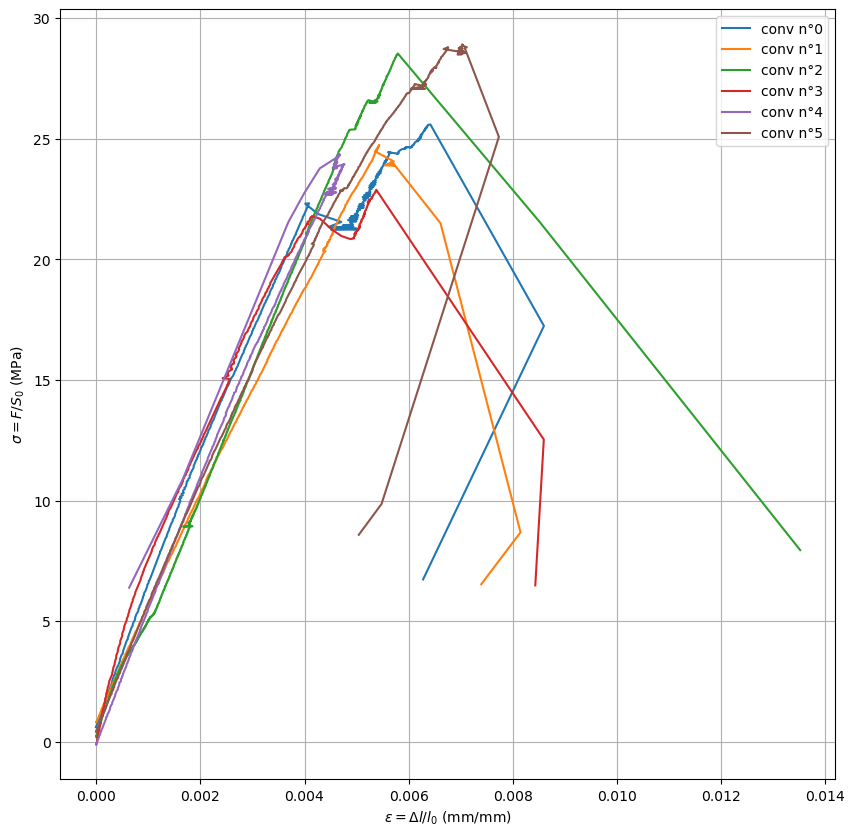

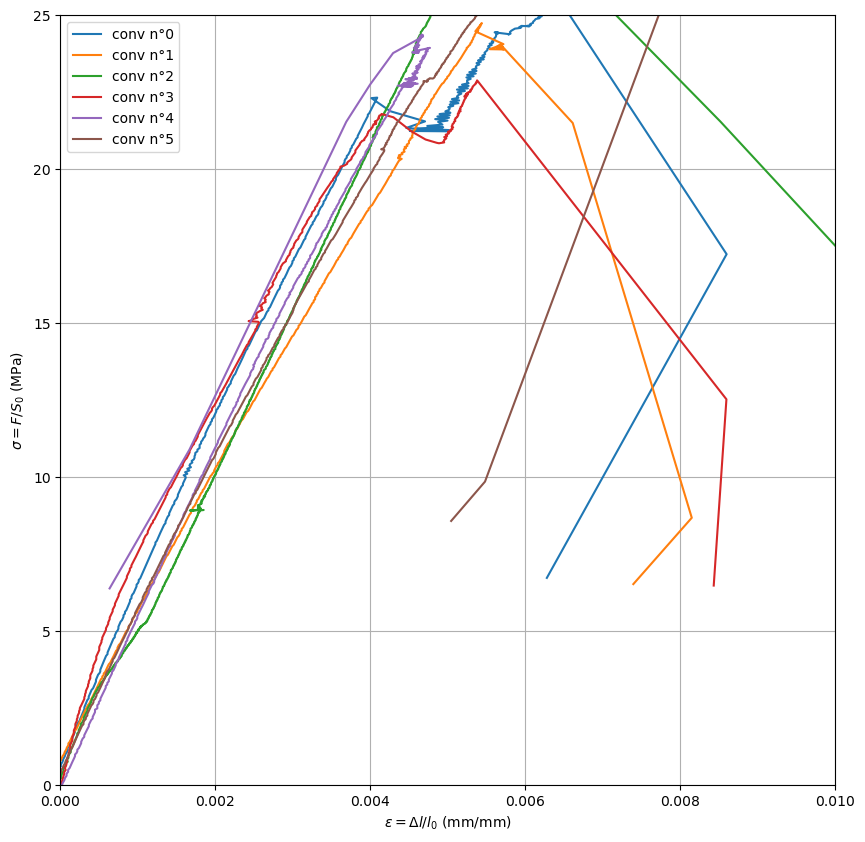

In [7]:
plt.figure(figsize=(10, 10))
plt.xlabel("$\epsilon=\Delta l/l_0$ (mm/mm)")


plt.ylabel("$\sigma=F/S_0$ (MPa)")


# plt.axis([0.0, 0.01, 0.0, 220.0])


for i in range(nb_exp):

    plt.plot(eps[i], sig[i], label=f"conv n°{i}")


plt.grid()


plt.legend(loc="best")


plt.show()


plt.figure(figsize=(10, 10))


plt.xlabel("$\epsilon=\Delta l/l_0$ (mm/mm)")


plt.ylabel("$\sigma=F/S_0$ (MPa)")


plt.axis([0.0, 0.01, 0.0, 25.0])


for i in range(nb_exp):

    plt.plot(eps[i], sig[i], label=f"conv n°{i}")


plt.grid()


plt.legend(loc="best")


plt.show()

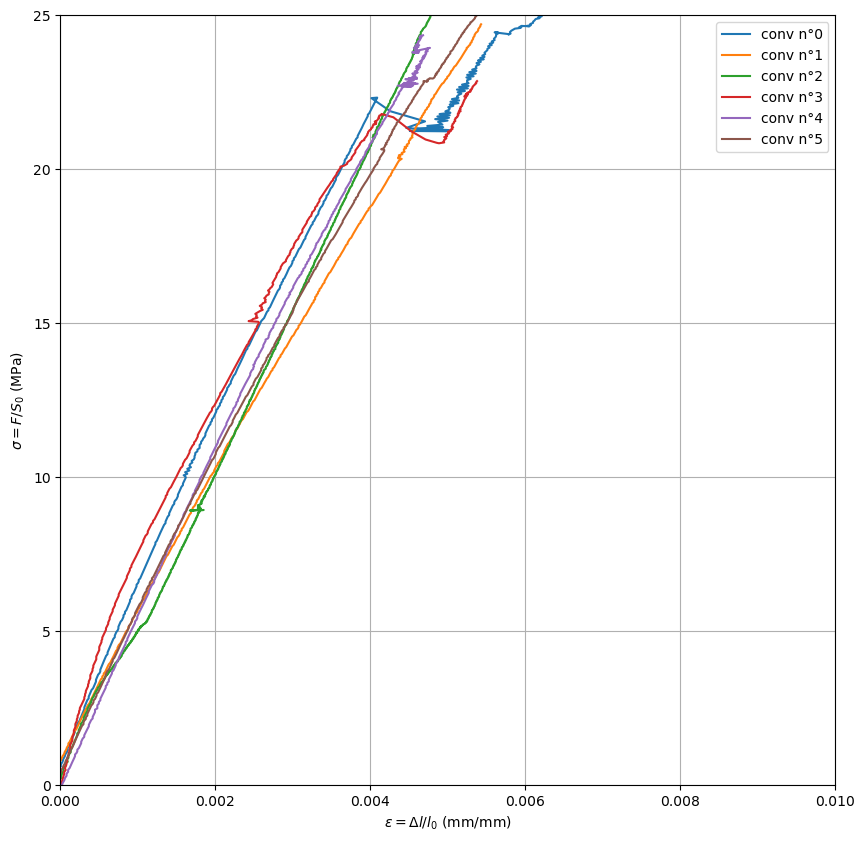

In [8]:
plt.figure(figsize=(10, 10))
plt.xlabel("$\epsilon=\Delta l/l_0$ (mm/mm)")


plt.ylabel("$\sigma=F/S_0$ (MPa)")


plt.axis([0.0, 0.01, 0.0, 25.0])


rejected_exps = []
selected_exp = [i for i in range(nb_exp) if i not in rejected_exps]

for i in selected_exp:

    plt.plot(eps_to_max[i], sig_to_max[i], label=f"conv n°{i}")


plt.grid()


plt.legend(loc="best")


plt.show()

On fait le choix de ne modéliser le bois que sur une plage où son comportement est inchangé et totalement linéaire.
On fixe de façon assez qualitative


In [9]:
eps_lim_e = 0.004
elastic_zone = [0.000, eps_lim_e]
elastic_zone_predicate = [
    (eps[i] <= elastic_zone[1]) & (eps[i] >= elastic_zone[0]) for i in range(nb_exp)
]

# restriction des données à la zone élastique
eps = [eps[i][elastic_zone_predicate[i]] for i in range(nb_exp)]
sig = [sig[i][elastic_zone_predicate[i]] for i in range(nb_exp)]

quadratic error = 0.8527382581466184


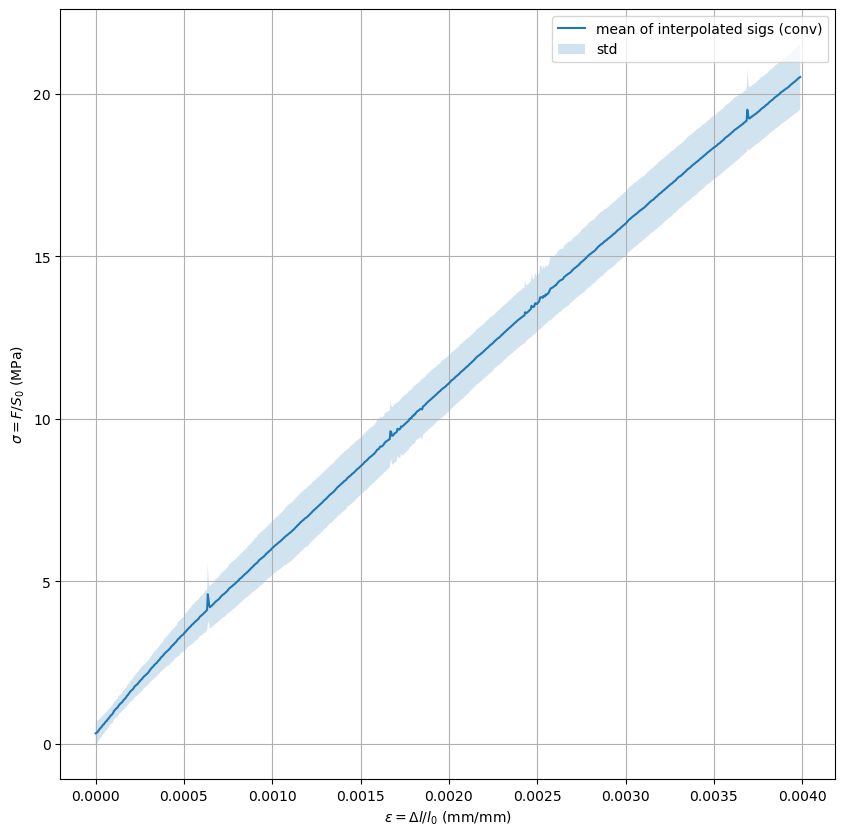

In [10]:
# select the best curves, interpolate them and compute their mean
interpolated_sig = [None] * nb_exp
for i in selected_exp:
    interpolated_sig[i] = interp1d(eps[i], sig[i])

eps_min = max([min(eps[i]) for i in selected_exp])
eps_max = min([max(eps[i]) for i in selected_exp])
delta = 1000

eps_finer = np.linspace(eps_min, eps_max, delta)
sig_finer = np.zeros((nb_exp, delta))

for i in selected_exp:
    sig_finer[i] = interpolated_sig[i](eps_finer)

# compute the mean of the interpolated curves
selected_sig_finer = sig_finer[selected_exp]
mean_sig = np.mean(selected_sig_finer, axis=0)
std_sig = np.std(selected_sig_finer, axis=0)
std_sig_no_nan = std_sig[~np.isnan(std_sig)]

# overall quadratic error
quad_err = np.sqrt(np.mean(std_sig_no_nan**2))

print(f"quadratic error = {quad_err}")

plt.figure(figsize=(10, 10))
plt.xlabel("$\epsilon=\Delta l/l_0$ (mm/mm)")
plt.ylabel("$\sigma=F/S_0$ (MPa)")
plt.plot(eps_finer, mean_sig, label="mean of interpolated sigs (conv)")
plt.fill_between(
    eps_finer, mean_sig - std_sig, mean_sig + std_sig, alpha=0.2, label="std"
)
plt.grid()
plt.legend(loc="best")
plt.show()

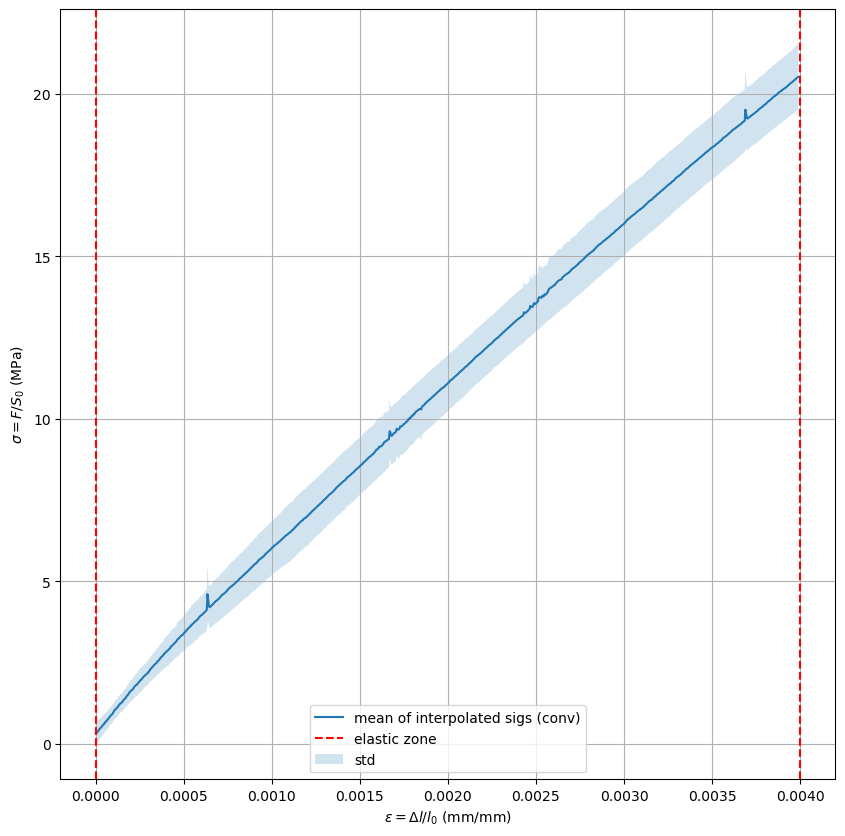

In [11]:
# compute slope of all selected curves on the interval [0.000, 0.002]


plt.figure(figsize=(10, 10))
plt.xlabel("$\epsilon=\Delta l/l_0$ (mm/mm)")
plt.ylabel("$\sigma=F/S_0$ (MPa)")
plt.plot(eps_finer, mean_sig, label="mean of interpolated sigs (conv)")
# add the elastic zone
plt.axvline(x=elastic_zone[0], color="r", linestyle="--", label="elastic zone")
plt.axvline(x=elastic_zone[1], color="r", linestyle="--")

plt.fill_between(
    eps_finer, mean_sig - std_sig, mean_sig + std_sig, alpha=0.2, label="std"
)
plt.grid()
plt.legend(loc="best")
plt.show()

In [12]:
slope = [None for _ in range(nb_exp)]
for i in selected_exp:
    # interpolate the curve
    # f = interp1d(eps_to_max[i], sig_to_max[i])
    f = interpolated_sig[i]
    # f = sig_finer[i]
    # compute the slope
    slope[i] = (f(elastic_zone[1] * 0.99) - f(elastic_zone[0])) / (
        elastic_zone[1] - elastic_zone[0]
    )

# compute the mean slope
mean_slope = np.mean([slope[i] for i in selected_exp])

# compute the standard deviation of the slope
std_slope = np.std([slope[i] for i in selected_exp])

print(f"mean slope: {mean_slope}")
print(f"std slope: {std_slope}")
for i in range(nb_exp):
    print(f"slope of curve {i}: {slope[i]}")

print()

mean slope: 5015.465232699011
std slope: 298.67752249201703
slope of curve 0: 5266.1498435650665
slope of curve 1: 4455.294896261918
slope of curve 2: 5072.947741358766
slope of curve 3: 5308.652329141699
slope of curve 4: 5179.947638013552
slope of curve 5: 4809.798947853062



In [13]:
# compute slope of previously interpolated mean curve
# compute indexes of the interpolated deformation that are closest to the elastic zone
idx_min = np.argmin(np.abs(eps_finer - elastic_zone[0]))
idx_max = np.argmin(np.abs(eps_finer - elastic_zone[1]))
print(eps_finer[idx_min], eps_finer[idx_max])

slope_mean_curve = np.polyfit(eps_finer[idx_min:idx_max], mean_sig[idx_min:idx_max], 1)[
    0
]

print(f"slope of the mean curve: {slope_mean_curve}")

E = slope_mean_curve

0.0 0.0039884393063583864
slope of the mean curve: 5011.556596045956


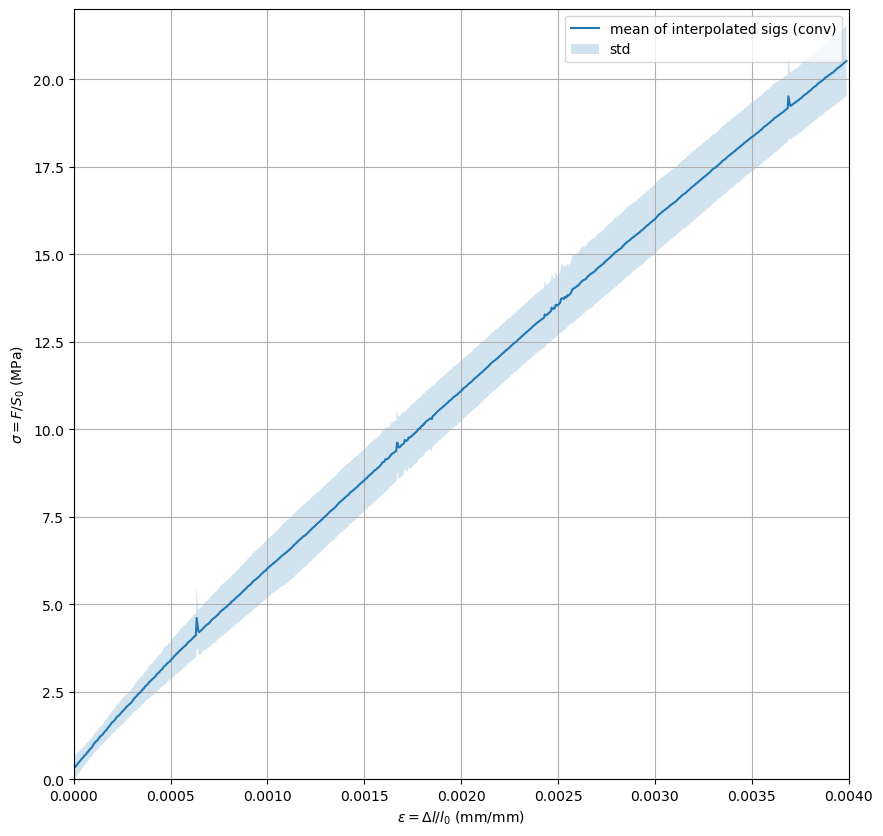

In [14]:
plt.figure(figsize=(10, 10))
plt.axis([elastic_zone[0], elastic_zone[1], 0, 22.0])
plt.xlabel("$\epsilon=\Delta l/l_0$ (mm/mm)")
plt.ylabel("$\sigma=F/S_0$ (MPa)")
plt.plot(eps_finer, mean_sig, label="mean of interpolated sigs (conv)")
plt.fill_between(
    eps_finer, mean_sig - std_sig, mean_sig + std_sig, alpha=0.2, label="std"
)
plt.grid()
plt.legend(loc="best")
plt.show()

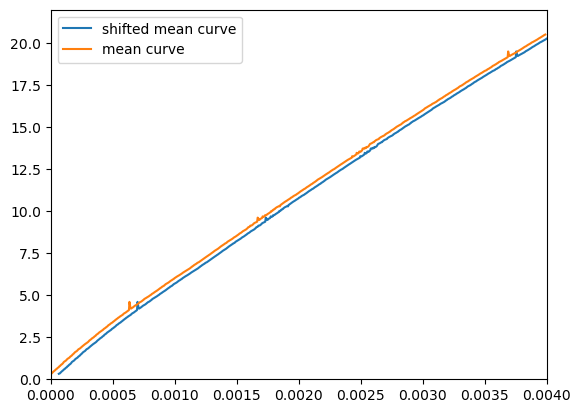

In [15]:
# shift the mean curve to the origin by the corresponding deformation
sig_0 = mean_sig[0]
shifted_eps_finer = eps_finer + sig_0 / E


plt.plot(shifted_eps_finer, mean_sig)
plt.plot(eps_finer, mean_sig)
plt.axis([elastic_zone[0], elastic_zone[1], 0, 22.0])
plt.legend(["shifted mean curve", "mean curve"])
plt.show()

Attention, on n'a pas réinterpolé la courbe shiftée des contraintes


In [16]:
# compute max stress (Rm)
finite_idx = np.isfinite(shifted_eps_finer) & np.isfinite(mean_sig)
Rm = np.max(mean_sig[finite_idx])
id_rm = np.argmax(mean_sig[finite_idx])

eps_to_max_finer = eps_finer[:id_rm]
sig_to_max_finer = mean_sig[:id_rm]

eps_to_rm = eps_to_max_finer[-1]

print(f"Rm = {Rm} MPa")
print(f"eps to Rm (%) = {100*eps_to_rm}")

Rm = 20.520280940677804 MPa
eps to Rm (%) = 0.39844468746202905


In [17]:
# compute the plastic deformation by subtracting the elastic deformation
eps_p = shifted_eps_finer - mean_sig / E

# compute the stress corresponding to a plastic strain of 0.002
conv_eps = 0.002
idx_conv_eps = np.argmin(np.abs(eps_p[:id_rm] - conv_eps))
# Rp02 = mean_sig[idx_conv_eps]
Rp02 = mean_sig[:id_rm][(eps_p[:id_rm] <= conv_eps)][-1]
# eps_p02 = eps_p[:id_rm][(eps_p[:id_rm] <= conv_eps)][-1]
eps_p02 = eps_p[idx_conv_eps]

print(f"eps02: {eps_p02}")
print(f"Rp02 = {Rp02} MPa")

eps02: 3.5657183690485024e-06
Rp02 = 20.50221380353977 MPa


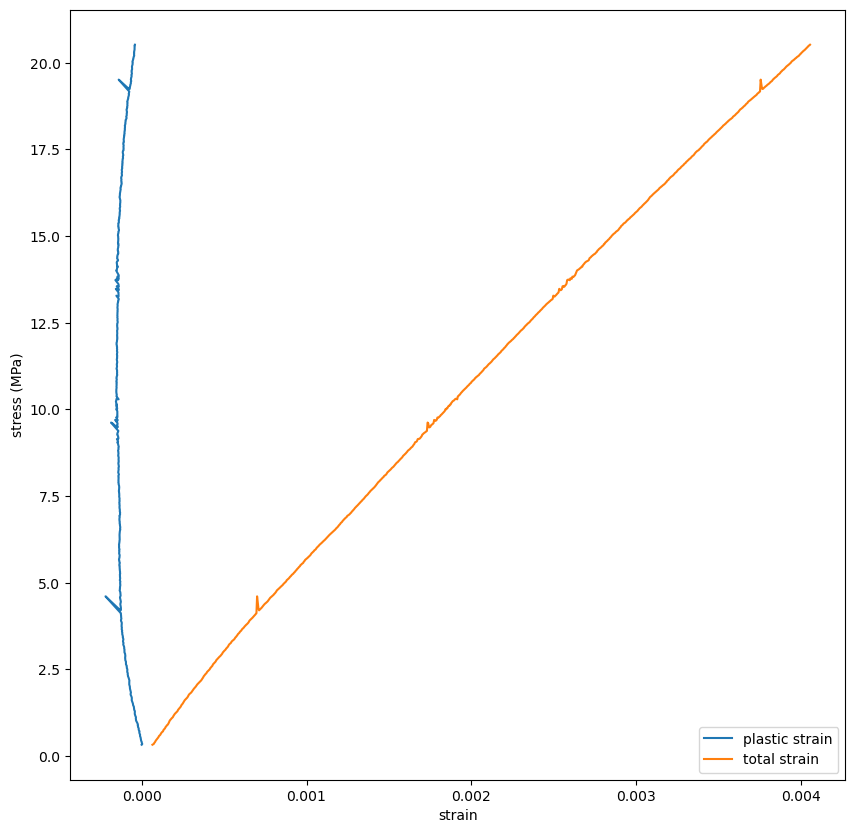

In [18]:
# plot the stress against the plastic strain and against the total strain
plt.figure(figsize=(10, 10))
plt.plot(eps_p, mean_sig)
plt.plot(shifted_eps_finer, mean_sig)
plt.xlabel("strain")
plt.ylabel("stress (MPa)")
plt.legend(["plastic strain", "total strain"])
plt.show()

In [19]:
# ~ Allongement uniforme (déformation plastique au maximum)

Au = eps_p[id_rm]

print(f"Au (%) = {100 * Au}")

Au (%) = -0.004087802457912893


quadratic error force = 105.44711174310784


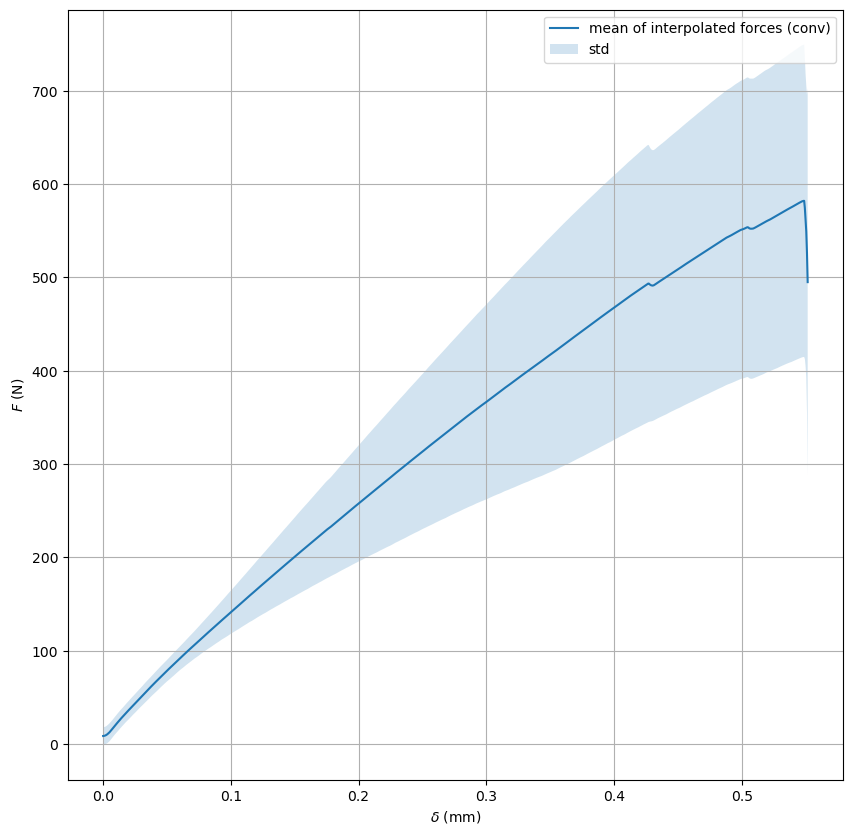

slope of the mean force curve: 1048.544058501995


In [20]:
# as for the strain-stress curve, interpolate all Verin-Force curves, choose an even discretization of the verin, and compute the mean curve
interpolated_verin = [None] * nb_exp
for i in selected_exp:
    interpolated_verin[i] = interp1d(Verin[i], Force[i])

verin_min = max([min(Verin[i]) for i in selected_exp])
verin_max = min([max(Verin[i]) for i in selected_exp])

verin_finer = np.linspace(verin_min, verin_max, delta)
force_finer = np.zeros((nb_exp, delta))

for i in selected_exp:
    force_finer[i] = interpolated_verin[i](verin_finer)

# compute the mean of the interpolated curves
selected_force_finer = force_finer[selected_exp]
mean_force = np.mean(selected_force_finer, axis=0)
std_force = np.std(selected_force_finer, axis=0)
std_force_no_nan = std_force[~np.isnan(std_force)]

# overall quadratic error
quad_err_force = np.sqrt(np.mean(std_force_no_nan**2))

print(f"quadratic error force = {quad_err_force}")

plt.figure(figsize=(10, 10))
plt.xlabel("$\delta$ (mm)")
plt.ylabel("$F$ (N)")
plt.plot(verin_finer, mean_force, label="mean of interpolated forces (conv)")
plt.fill_between(
    verin_finer, mean_force - std_force, mean_force + std_force, alpha=0.2, label="std"
)
plt.grid()
plt.legend(loc="best")
plt.show()

# compute the slope of the mean force curve
Kv = np.polyfit(verin_finer[idx_min:idx_max], mean_force[idx_min:idx_max], 1)[0]
print(f"slope of the mean force curve: {Kv}")

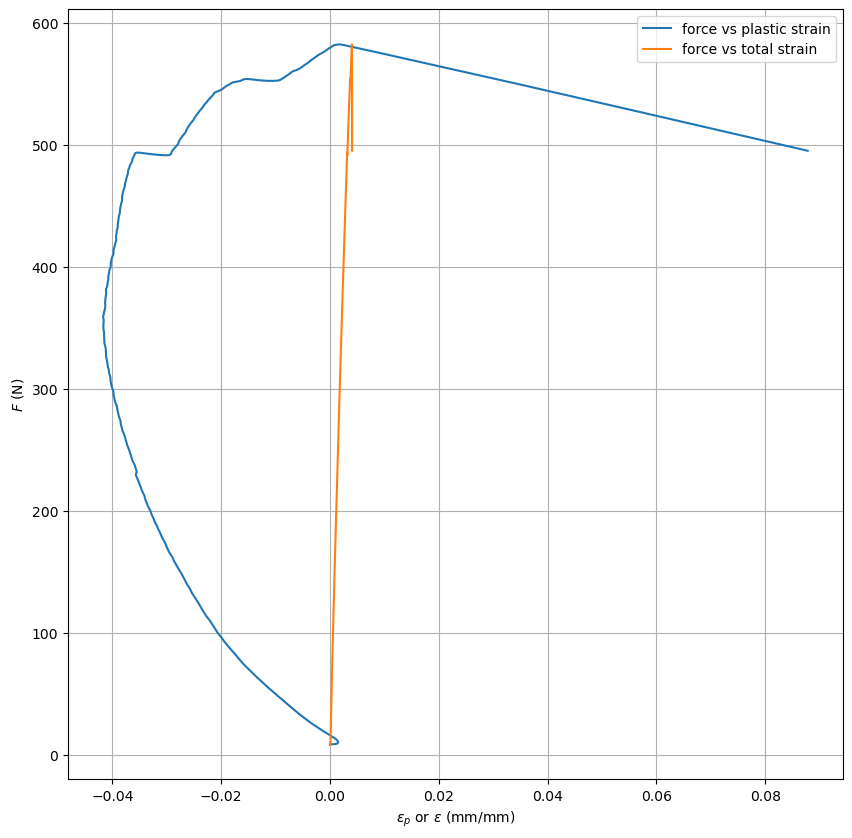

In [21]:
# shift the force curve to the origin
force_0 = mean_force[0]
shifted_verin_finer = verin_finer + force_0 / Kv

# compute plastic strain from the verin
eps_p_verin = shifted_verin_finer - mean_force / Kv

# plot the force against plastic strain and against the total strain computed from the verin
plt.figure(figsize=(10, 10))
plt.xlabel("$\epsilon_p$ or $\epsilon$ (mm/mm)")
plt.ylabel("$F$ (N)")
plt.plot(eps_p_verin, mean_force)
plt.plot(shifted_eps_finer, mean_force)
plt.grid()
plt.legend(["force vs plastic strain", "force vs total strain"])
plt.show()

### identification de la rigidité de machine


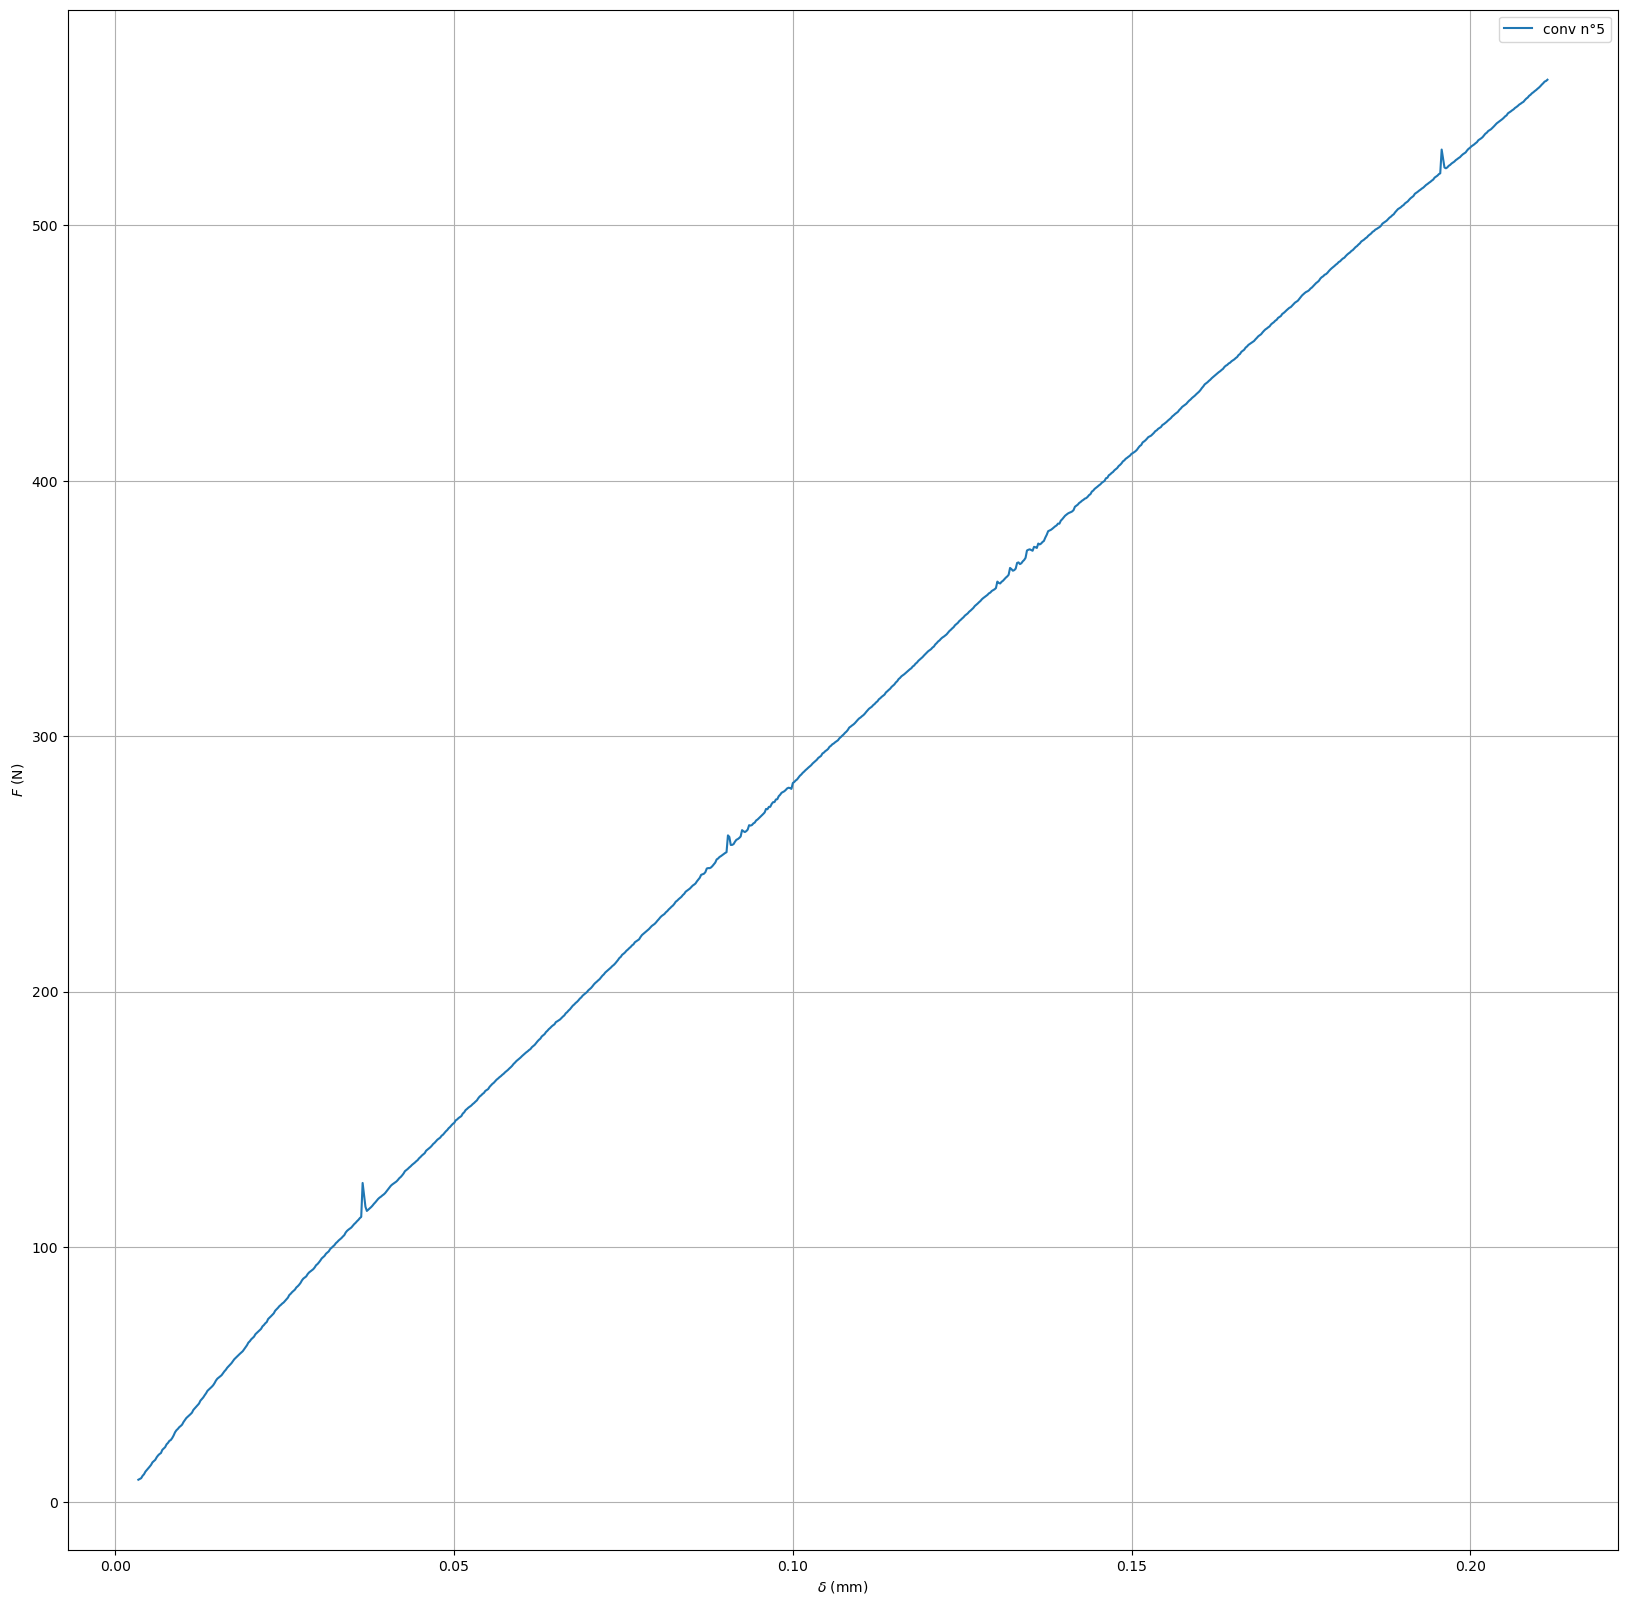

In [22]:
# la pente de la rigidité liée à l'éprouvette est celle de la courbe force-déplacement obtenue à partir des contraintes-déformations ingénieurs remultipliées par S0 et l0
plt.figure(figsize=(20, 20))


force_stress = mean_sig * s0_mean
deformation_strain = shifted_eps_finer * l0_mean


plt.plot(deformation_strain, force_stress, label=f"conv n°{i}")

plt.xlabel("$\delta$ (mm)")
plt.ylabel("$F$ (N)")
plt.grid()
plt.legend(loc="best")
plt.show()

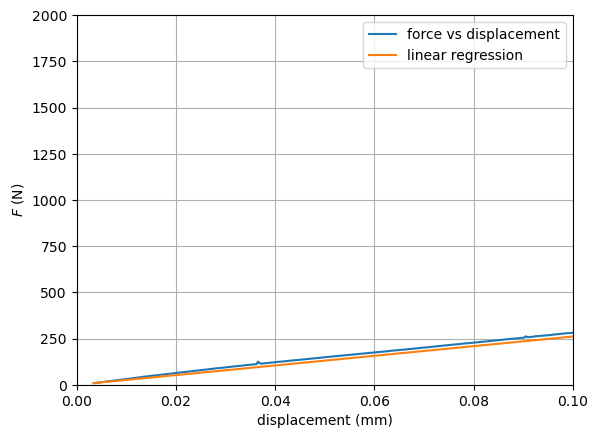

In [23]:
# compute rigidity of tensile
K_tensile = np.polyfit(
    deformation_strain[idx_min:idx_max], force_stress[idx_min:idx_max], 1
)[0]
Force_tens_lin = K_tensile * deformation_strain

plt.plot(deformation_strain, force_stress)
plt.plot(deformation_strain, Force_tens_lin)
plt.xlabel("displacement (mm)")
plt.ylabel("$F$ (N)")
plt.grid()
plt.legend(["force vs displacement", "linear regression"])
plt.axis([0, 0.1, 0, 2000])
plt.show()

In [24]:
# compute rigidity of machine
Km = 1 / (1 / Kv - 1 / K_tensile)

In [25]:
print(Km)

1753.2755975129191


### Ecriture des résultats


In [29]:
infos = []
infos.append("E: %g" % (E))
infos.append("Rp02: %g" % (Rp02))
infos.append("Rm: %g" % (Rm))
infos.append("Au: %g" % (Au))
infos.append("A: %g" % (-1))
infos.append("strain rate: %g" % (-1))
infos.append("eps to rm: %g" % (eps_to_rm))
infos.append("Kv: %g" % (Kv))
infos.append("Km: %g" % (Km))
infos.append("Kt: %g" % (K_tensile))

fic = open(exp_prefix + ".info", "w")
for info in infos:
    fic.writelines(info + "\n")
fic.close()

# ~ Si on veut lire l'ensemble du fichier il suffit d'ouvrir le fichier en lecture comme suit :
f = open(exp_prefix + ".info", "r")
infos = f.read()
f.close
print(infos)

E: 5011.56
Rp02: 20.5022
Rm: 20.5203
Au: -4.0878e-05
A: -1
strain rate: -1
eps to rm: 0.00398445
Kv: 1048.54
Km: 1753.28
Kt: 2608.63



### Calcul et tracé des déformations vraies


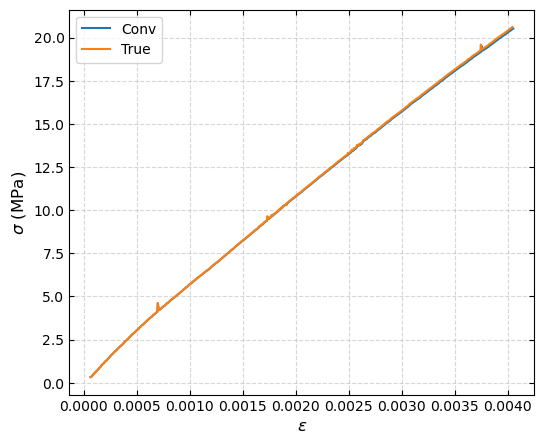

In [27]:
eps_true = np.log(1.0 + shifted_eps_finer)
sig_true = mean_sig * (1 + shifted_eps_finer)

fig = plt.figure(figsize=(6, 5))
plt.xlabel(r"$\varepsilon$", fontsize=12)
plt.ylabel(r"$\sigma$ (MPa)", fontsize=12)
plt.tick_params(top=True, right=True, direction="in")
plt.grid(linestyle="--", alpha=0.5)
# plt.axis([0.0, 1.5 * eps_shift[id_rm], 0.0, 1.5 * Rm])
plt.plot(shifted_eps_finer, mean_sig, label="Conv")
plt.plot(eps_true, sig_true, label="True")
plt.legend(loc="best")
plt.show()

### Ecriture des courbes résultats


In [28]:
dlp_L0 = np.zeros((len(shifted_eps_finer),))
tps_result = np.zeros((len(shifted_eps_finer),))

np.savetxt(
    exp_prefix + ".res",
    np.c_[tps_result, shifted_eps_finer, dlp_L0, eps_true, mean_sig, sig_true],
    delimiter=" ",
    fmt="%.10f %.10f %.10f %.10f %.10f %.10f",
    header="time(1) dl/l0(2) dlp/L0(3) e_tru(4) F/S0(5) s_tru(6)",
)